In [4]:
import numpy as np
import matplotlib.pyplot as plt
import PySimpleGUI as sg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import chirp, spectrogram
import scipy.fft as fft
import os
import nidaqmx as ni
from nidaqmx.constants import WAIT_INFINITELY
from nidaqmx.constants import Slope
from nidaqmx.constants import TaskMode
import time

In [5]:
%run Variables_Functions.ipynb
%run Tabs.ipynb

The current working directory is /home/ian/Acoustic-Analysis


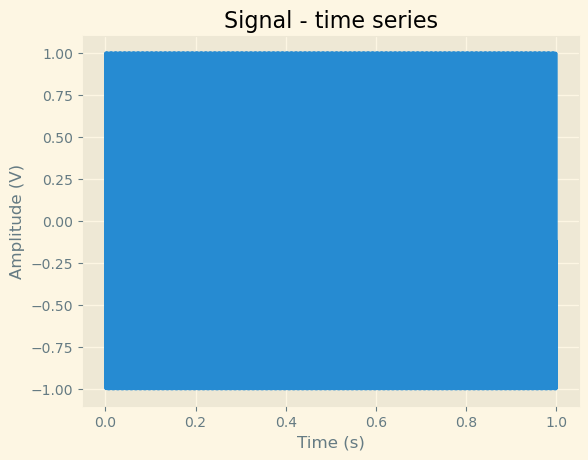

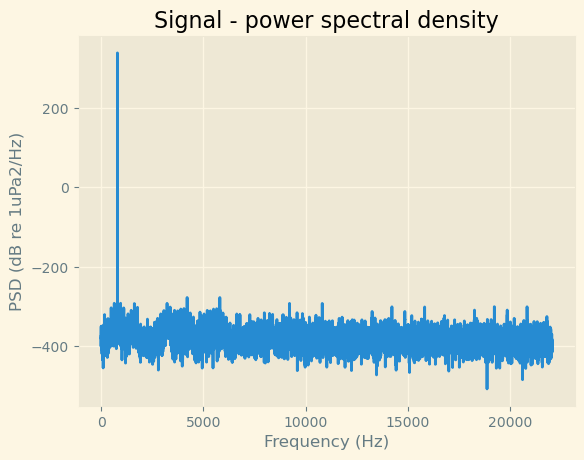

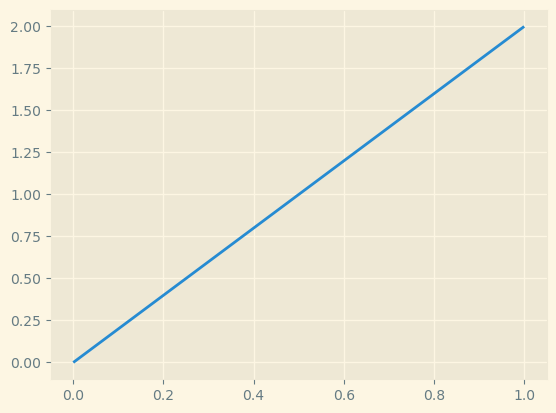

In [6]:
i = 0 # Use i so we can make multiple recordings in the same folder
j = 0 # Use j so we can update the measured graphs
k = 0 # Use k so we can make a new wave file
tab_group = [
                [sg.TabGroup(
                    [[
                        sg.Tab('Configuration', FrontPage_layout, background_color = '#FDF6E3'),
                        sg.Tab('Signal Generation', SigGen_layout, background_color = '#FDF6E3'),                 
                        sg.Tab('Measurement', Measurement_layout, background_color = '#FDF6E3')
                    ]],
                    tab_location = 'centertop',
                    title_color = 'Black', 
                    tab_background_color = '#C4BEAC',
                    selected_title_color = 'Black',
                    selected_background_color = '#E4FAFF',
                    background_color = '#FDF6E3'),
                    sg.Button('Exit')  
                ]
            ]
         

_VARS['window'] = sg.Window('Random Samples',
                            tab_group,
                            finalize=True,
                            resizable=True,
                            location=(100, 100),
                            element_justification="center",
                            background_color='#FDF6E3')


drawTimeSeriesTx()
drawPSDTx()
drawRMS()

local = ni.system.System.local()


# MAIN LOOP
while True:
    devices = query_devices()
    SetLED(_VARS['window'], '_DAQ_', 'green' if devices else 'red')
    #print( _VARS['output_channel'])
    _VARS['sensor_data'] = [[_VARS['output_channel'][i]] for i in range(len(_VARS['output_channel']))]
    for i in range(len(_VARS['sensor_data'])):
        _VARS['sensor_data'][i].append(1)
    #print( _VARS['sensor_data'])
    update_table(_VARS['window'], '-TABLE-')
    time.sleep(1)
    event, values = _VARS['window'].read(timeout=200)
    if event == sg.WIN_CLOSED or event == 'Exit':
        break
    elif event == 'Submit':
        generate_directory_name(str(values['-directory_name-']))
        #path = os.getcwd()
        #print ("The current working directory is %s" % path)
        #print ("The stored working directory is %s" % _VARS['directory_name'])
    elif event == 'Resample':
        updateChart()
    elif event == 'OK':
        updateParameters(float(values['-max_frequency-']),float(values['-frequency-']), \
                         float(values['-peak_amplitude-']),float(values['-sampling_rate-']), \
                         float(values['-pulse_time-']), str(values['-pulse_type-']))
    elif event == 'Start':
        recordADC()
        print(j)
        

        
        # print(int(values['-Slider-']))
_VARS['window'].close()


In [ ]:
path = os.getcwd()
print ("The current working directory is %s" % path)

The current working directory is /home/ian/Acoustic-Analysis


In [4]:
print(int(_VARS['sampling_rate']))

44100


In [ ]:
plt.plot(indata)

In [37]:

def query_devices():
  local = ni.system.System.local()
  for device in local.devices:
    print('Device Name: {device.name}, Product Type: {device.product_type}')
    print('Input channels:', [chan.name for chan in device.ai_physical_chans])
    print('Output channels:', [chan.name for chan in device.ao_physical_chans])
    #return device.name



In [15]:
x, y = query_devices()
print(x)
print(y)

['cDAQ1', 'cDAQ1Mod1', 'cDAQ1Mod2']
['cDAQ1Mod2/ao0', 'cDAQ1Mod2/ao1']


In [62]:
query_devices()
print(devices)
print(output_channel)

['cDAQ1', 'cDAQ1Mod1', 'cDAQ1Mod2']
['cDAQ1Mod2/ao0', 'cDAQ1Mod2/ao1']


In [24]:
def query_devices():
    local = ni.system.System.local()
    device1 = local.devices[0].name
    return local.devices[0].name



In [ ]:
def query_DAQ():
    local = None
    local = ni.system.System.local()
    return local
    

In [26]:
query_devices()

'cDAQ1'

In [25]:
print(device1)

NameError: name 'device1' is not defined

In [1]:
#!/usr/bin/env python
import PySimpleGUI as sg
import time
import random

"""
    Demo program showing how to create your own "LED Indicators"
    The LEDIndicator function acts like a new Element that is directly placed in a window's layout
    After the Window is created, use the SetLED function to access the LED and set the color

"""


def LEDIndicator(key=None, radius=30):
    return sg.Graph(canvas_size=(radius, radius),
             graph_bottom_left=(-radius, -radius),
             graph_top_right=(radius, radius),
             pad=(0, 0), key=key)

def SetLED(window, key, color):
    graph = window[key]
    graph.erase()
    graph.draw_circle((0, 0), 12, fill_color=color, line_color=color)


layout = [[sg.Text('My LED Status Indicators', size=(20,1))],
          [sg.Text('CPU Use'), LEDIndicator('_cpu_')],
          [sg.Text('RAM'), LEDIndicator('_ram_')],
          [sg.Text('Temperature'), LEDIndicator('_temp_')],
          [sg.Text('Server 1'), LEDIndicator('_server1_')],
          [sg.Button('Exit')]]

window = sg.Window('My new window', layout, default_element_size=(12, 1), auto_size_text=False, finalize=True)

i = 0
while True:  # Event Loop
    event, value = window.read(timeout=400)
    if event == 'Exit' or event == sg.WIN_CLOSED:
        break
    if value is None:
        break
    i += 1
    SetLED(window, '_cpu_', 'green' if random.randint(1, 10) > 5 else 'red')
    SetLED(window, '_ram_', 'green' if random.randint(1, 10) > 5 else 'red')
    SetLED(window, '_temp_', 'green' if random.randint(1, 10) > 5 else 'red')
    SetLED(window, '_server1_', 'green' if random.randint(1, 10) > 5 else 'red')
window.close()


In [11]:
def query_devices():
    devices = []
    output_channel = []
    local = ni.system.System.local()
    for device_num in range(len(local.devices)):
        devices.append(local.devices[device_num].name)
        for ao in range(len(local.devices[device_num].ao_physical_chans)):
            output_channel.append(local.devices[device_num].ao_physical_chans[ao].name)
    
    return devices, output_channel

In [14]:
x, y = query_devices()

In [15]:
y[0]

'cDAQ1Mod2/ao0'

In [29]:
data_list = ['cat','mouse']
new_list = [[data_list[i]] for i in range(len(data_list))]
for i in range(len(new_list)):
    new_list[i].append(1)

In [30]:
new_list

[['cat', 1], ['mouse', 1]]

In [19]:
for i in range(len(new_list)):
    new_list[i].append(1)

In [20]:
new_list

[[0, 1], [1, 1]]

In [15]:
my_list = ['a', ['bb', 'cc'], 'd']
my_list[1].append('xx')
print(my_list)
# Prints ['a', ['bb', 'cc', 'xx'], 'd']

['a', ['bb', 'cc', 'xx'], 'd']
